# Aggregated Load using LSTM

### Data Sources
* Location: Austin, TX
* Dates: 2016-01-01 to 2017-06-30
* Weather: Weather Underground. 
 * Link: https://www.wunderground.com/
 * Data resolution: ~ 1 hour
 * Access: open
* Energy: Pecan Street. 
 * Link: http://www.pecanstreet.org/
 * Data resolution: 1 minute
 * Access: universities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                        
%matplotlib inline

def load_data(filename):
	data = pd.read_csv(filename, index_col="datetime")
	return data

## Raw Data

### Energy Data

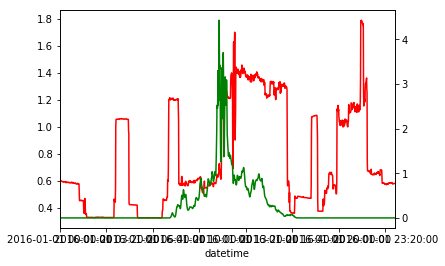

In [2]:
## for a single house
resol = 1
households = [93, 114, 370, 545, 585, 661, 744, 1192, 1642,
				  1718, 1800, 1801, 2018, 2129, 2233, 2337, 2461,
				  2575, 2638, 2814, 2818]
# example: 2018, 2129, 2233, 2335, 2337, 2461, 2575, 2814
household = 93

raw_energy = load_data("preparedData/energy" + str(resol) + "_" + str(household) + ".csv")
raw_energy = raw_energy.loc['2015-12-24 00:00:00':'2017-06-30 23:59:00']

raw_energy.loc['2016-01-01 00:00:00':'2016-01-01 23:59:00']['use'].plot(style='r')
raw_energy.loc['2016-01-01 00:00:00':'2016-01-01 23:59:00']['gen'].plot(secondary_y=True, style='g')


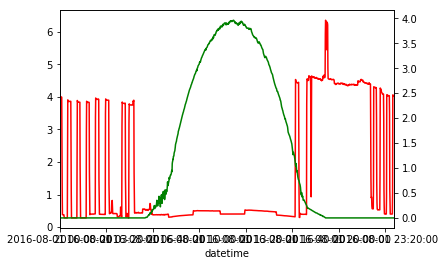

In [3]:
raw_energy.loc['2016-08-01 00:00:00':'2016-08-01 23:59:00']['use'].plot(style='r')
raw_energy.loc['2016-08-01 00:00:00':'2016-08-01 23:59:00']['gen'].plot(secondary_y=True, style='g')

In [3]:
# for all the houses
resol = 1
# load households aggregated data
for i, household in enumerate(households):
    energy = load_data("preparedData/energy" + str(resol) + "_" + str(household) + ".csv")
    energy = energy.loc['2015-12-24 00:00:00':'2017-06-30 23:00:00']
    if i == 0:
        energyAgg = energy
    else:
        energyAgg += energy

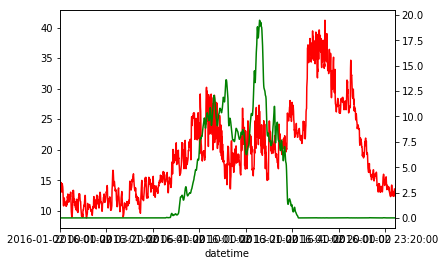

In [4]:
energyAgg.loc['2016-01-02 00:00:00':'2016-01-02 23:59:00']['use'].plot(style='r')
energyAgg.loc['2016-01-02 00:00:00':'2016-01-02 23:59:00']['gen'].plot(secondary_y=True, style='g')

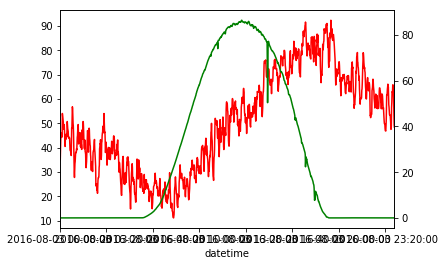

In [6]:
energyAgg.loc['2016-08-03 00:00:00':'2016-08-03 23:59:00']['use'].plot(style='r')
energyAgg.loc['2016-08-03 00:00:00':'2016-08-03 23:59:00']['gen'].plot(secondary_y=True, style='g')

## Data interpolated adjusted to desired resolution

In [5]:
# forecast resolution
resol = 60

# load households aggregated data
for i, household in enumerate(households):
    energy = load_data("preparedData/energy" + str(resol) + "_" + str(household) + ".csv")
    energy = energy.loc['2015-12-24 00:00:00':'2017-06-30 23:00:00']
    if i == 0:
        energyAgg = energy
    else:
        energyAgg += energy
    

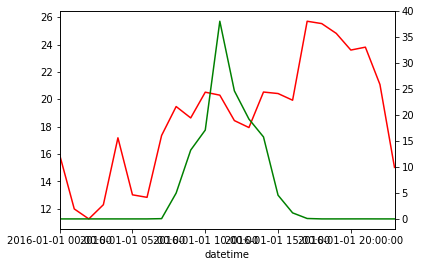

In [6]:
# load
energyAgg.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['use'].plot(style='r')
energyAgg.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['gen'].plot(secondary_y=True, style='g')

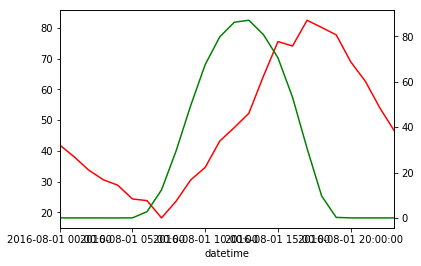

In [7]:
# load
energyAgg.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['use'].plot(style='r')
energyAgg.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['gen'].plot(secondary_y=True, style='g')

                           hum     tempC
datetime                                
2014-12-30 00:00:00  85.000000  6.700000
2014-12-30 01:00:00  85.040000  6.694000
2014-12-30 02:00:00  87.575315  6.312892
2014-12-30 03:00:00  92.543018  5.703941
2014-12-30 04:00:00  97.666667  6.058333


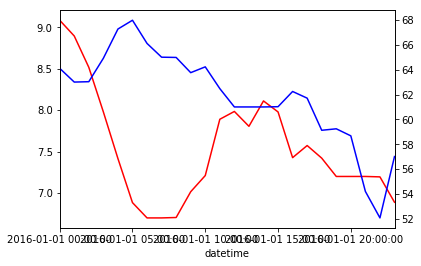

In [8]:
# load weather data
weather = load_data("preparedData/weather" + str(resol) + ".csv")
print(weather.head())

weather.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['tempC'].plot(style='r')
weather.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['hum'].plot(secondary_y=True, style='b')

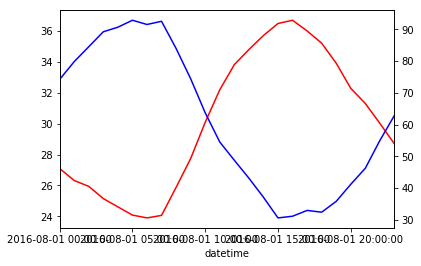

In [9]:
weather.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['tempC'].plot(style='r')
weather.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['hum'].plot(secondary_y=True, style='b')

# Power Demand Forecasting

### Prepare Dataset to Feed LSTM

In [10]:
from datetime import date, datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

days = [1, 2, 7]
def prepare_dataset_pv(weather, energy, resol, days):
	val_days = [1, 2, 3, 4, 5, 6, 7]
    
	# chunk data in days
	weather = weather.loc['2016-01-01':'2017-07-01']
	
	startDate = date(2016, 1, 1)
	endDate = date(2017, 6, 30)
	

	
	if resol == 60:
		minSt = '00'
	elif resol == 30:
		minSt = '30'
	elif resol == 15:
		minSt = '45'
		
	countTrain = 1
	countTest = 1
	countVal = 1
	
	while startDate <= endDate:
		startDateSt = startDate.strftime('%Y-%m-%d')
		startDatetimeSt = startDateSt + ' 00:00:00'
		endDatetimeSt = startDateSt +' 23:' + minSt + ':00'
		x = weather.loc[startDatetimeSt:endDatetimeSt]
		x = x.reset_index(drop=True)
		
		
        
		for day in days:
			# last week consumption
			date_past = startDate - timedelta(days=day)
			date_past = date_past.strftime('%Y-%m-%d')
			startDatetimeSt = date_past + ' 00:00:00'
			endDatetimeSt = date_past + ' 23:' + minSt + ':00'
			x_i = energy.loc[startDatetimeSt:endDatetimeSt]
			'''
			x_i = pd.DataFrame([x_i])
			'''
			x_i = x_i.reset_index(drop=True)
			column_name = 'day_' + str(day)
			x_i = pd.DataFrame(x_i['use'])
			x[column_name] = x_i
		
		x = x.as_matrix()
		#print(x.shape)
		x = x.reshape(1,x.shape[0], x.shape[1])
		#print(x.shape)
		
		
		
		# output on this day
		y = energy.loc[startDatetimeSt:endDatetimeSt]
		y = y.reset_index(drop=True)
		y = pd.DataFrame(y['use']).as_matrix()
		#print(y.shape)
		y = y.reshape(1, y.shape[0])
		#print(y.shape)
		
		if startDate < date(2017, 1, 1):
			day = startDate.day
			if int(day) in val_days:
				# validation set
				if countVal == 1:
					x_val = x
					y_val = y
					countVal += 1
				else:
					x_val = np.concatenate((x_val, x), axis=0)
					y_val = np.concatenate((y_val, y), axis=0)
			else:
				# training set
				if countTrain == 1:
					x_train = x
					y_train = y
					countTrain += 1
				else:
					x_train = np.concatenate((x_train, x), axis=0)
					y_train = np.concatenate((y_train, y), axis=0)
		elif startDate < date(2017, 7, 1):
			if countTest == 1:
				x_test = x
				y_test = y
				countTest += 1
			else:
				x_test = np.concatenate((x_test, x), axis=0)
				y_test = np.concatenate((y_test, y), axis=0)
		
		# update date
		startDate = startDate + timedelta(days=1)
		
	
	print(x_train.shape)
	print(y_train.shape)
	print(x_val.shape)
	print(y_val.shape)
	print(x_test.shape)
	print(y_test.shape)
	
	# ensure all data is float
	x_train = x_train.astype('float32')
	y_train = y_train.astype('float32')
	x_val = x_val.astype('float32')
	y_val = y_val.astype('float32')
	x_test = x_test.astype('float32')
	y_test = y_test.astype('float32')
    

    
	n_features = x_train.shape[2]
	x_train = x_train.reshape((-1, n_features))
	x_val = x_val.reshape((-1, n_features))
	x_test = x_test.reshape((-1, n_features))
	
	scalerFeatures = MinMaxScaler(feature_range=(0, 1))
	x_train = scalerFeatures.fit_transform(x_train)
	x_val = scalerFeatures.transform(x_val)
	x_test = scalerFeatures.transform(x_test)
	
	x_train = x_train.reshape((-1, 1440//resol, n_features))
	x_val = x_val.reshape((-1, 1440//resol, n_features))
	x_test = x_test.reshape((-1, 1440//resol, n_features))
	
	# Normalize y
	y_train = y_train.reshape((-1))
	y_val = y_val.reshape((-1))
	y_test = y_test.reshape((-1))
	
	scalerOutput = MinMaxScaler(feature_range=(0, 1))
	y_train = scalerOutput.fit_transform(y_train)
	y_val = scalerOutput.transform(y_val)
	y_test = scalerOutput.transform(y_test)
	
	y_train = y_train.reshape((-1, 1440//resol))
	y_val = y_val.reshape((-1, 1440//resol))
	y_test = y_test.reshape((-1, 1440//resol))
	
	print(x_train.shape)
	print(y_train.shape)
	print(x_val.shape)
	print(y_val.shape)
	print(x_test.shape)
	print(y_test.shape)
	
	return x_train, y_train, x_val, y_val, x_test, y_test, scalerFeatures, scalerOutput

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test, scalerFeatures, scalerOutput\
		= prepare_dataset_pv(weather, energy, resol, days)

(282, 24, 5)
(282, 24)
(84, 24, 5)
(84, 24)
(181, 24, 5)
(181, 24)
(282, 24, 5)
(282, 24)
(84, 24, 5)
(84, 24)
(181, 24, 5)
(181, 24)


/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your dat

### Define RNN Model

In [13]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense

timesteps = 1440//resol
input_shape = (x_train.shape[1], x_train.shape[2])

# design network
modelLoad = Sequential()
modelLoad.add(LSTM(timesteps, return_sequences=True, input_shape=input_shape))
modelLoad.add(LSTM(timesteps))
modelLoad.add(Dense(timesteps, activation='sigmoid'))
print(modelLoad.summary())

# compilation
# model.compile(loss='mae', optimizer='adam')
modelLoad.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 24)            2880      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 8,184
Trainable params: 8,184
Non-trainable params: 0
_________________________________________________________________
None


### Training Model 

Train on 282 samples, validate on 84 samples
Epoch 1/1000
Epoch 00000: val_loss improved from inf to 0.00265, saving model to saved_models/weights.best.aggre_load_60.hdf5
0s - loss: 0.0017 - val_loss: 0.0027
Epoch 2/1000
Epoch 00001: val_loss improved from 0.00265 to 0.00264, saving model to saved_models/weights.best.aggre_load_60.hdf5
0s - loss: 0.0017 - val_loss: 0.0026
Epoch 3/1000
Epoch 00002: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0026
Epoch 4/1000
Epoch 00003: val_loss improved from 0.00264 to 0.00261, saving model to saved_models/weights.best.aggre_load_60.hdf5
0s - loss: 0.0018 - val_loss: 0.0026
Epoch 5/1000
Epoch 00004: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0027
Epoch 6/1000
Epoch 00005: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0027
Epoch 7/1000
Epoch 00006: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0029
Epoch 8/1000
Epoch 00007: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0030
Epoch 9/1000
Epoch

Epoch 00083: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0026
Epoch 85/1000
Epoch 00084: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0027
Epoch 86/1000
Epoch 00085: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0027
Epoch 87/1000
Epoch 00086: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0028
Epoch 88/1000
Epoch 00087: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0029
Epoch 89/1000
Epoch 00088: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0029
Epoch 90/1000
Epoch 00089: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0029
Epoch 91/1000
Epoch 00090: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0028
Epoch 92/1000
Epoch 00091: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0029
Epoch 93/1000
Epoch 00092: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0028
Epoch 94/1000
Epoch 00093: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0029
Epoch 95/1000
Epoch 00094: val_loss

Epoch 00172: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0026
Epoch 174/1000
Epoch 00173: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0026
Epoch 175/1000
Epoch 00174: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0026
Epoch 176/1000
Epoch 00175: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0026
Epoch 177/1000
Epoch 00176: val_loss improved from 0.00257 to 0.00256, saving model to saved_models/weights.best.aggre_load_60.hdf5
0s - loss: 0.0014 - val_loss: 0.0026
Epoch 178/1000
Epoch 00177: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0026
Epoch 179/1000
Epoch 00178: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0026
Epoch 180/1000
Epoch 00179: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0026
Epoch 181/1000
Epoch 00180: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0026
Epoch 182/1000
Epoch 00181: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0026
Epoch 183/1000
Epoch 00182: val_loss

Epoch 00262: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0026
Epoch 264/1000
Epoch 00263: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0026
Epoch 265/1000
Epoch 00264: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0026
Epoch 266/1000
Epoch 00265: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0027
Epoch 267/1000
Epoch 00266: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0027
Epoch 268/1000
Epoch 00267: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0027
Epoch 269/1000
Epoch 00268: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0027
Epoch 270/1000
Epoch 00269: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0027
Epoch 271/1000
Epoch 00270: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0026
Epoch 272/1000
Epoch 00271: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0027
Epoch 273/1000
Epoch 00272: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0027
Epoch 274/1000
Epoch 0027

Epoch 00354: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0027
Epoch 356/1000
Epoch 00355: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0027
Epoch 357/1000
Epoch 00356: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0027
Epoch 358/1000
Epoch 00357: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0026
Epoch 359/1000
Epoch 00358: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0026
Epoch 360/1000
Epoch 00359: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0026
Epoch 361/1000
Epoch 00360: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0027
Epoch 362/1000
Epoch 00361: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0027
Epoch 363/1000
Epoch 00362: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0026
Epoch 364/1000
Epoch 00363: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0026
Epoch 365/1000
Epoch 00364: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0026
Epoch 366/1000
Epoch 0036

Epoch 00446: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0026
Epoch 448/1000
Epoch 00447: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0026
Epoch 449/1000
Epoch 00448: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0026
Epoch 450/1000
Epoch 00449: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0026
Epoch 451/1000
Epoch 00450: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0027
Epoch 452/1000
Epoch 00451: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0027
Epoch 453/1000
Epoch 00452: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0028
Epoch 454/1000
Epoch 00453: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0026
Epoch 455/1000
Epoch 00454: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0026
Epoch 456/1000
Epoch 00455: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0026
Epoch 457/1000
Epoch 00456: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0026
Epoch 458/1000
Epoch 0045

Epoch 00537: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 539/1000
Epoch 00538: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 540/1000
Epoch 00539: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 541/1000
Epoch 00540: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 542/1000
Epoch 00541: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 543/1000
Epoch 00542: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 544/1000
Epoch 00543: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 545/1000
Epoch 00544: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 546/1000
Epoch 00545: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 547/1000
Epoch 00546: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0027
Epoch 548/1000
Epoch 00547: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0026
Epoch 549/1000
Epoch 0054

Epoch 00629: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 631/1000
Epoch 00630: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0027
Epoch 632/1000
Epoch 00631: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0027
Epoch 633/1000
Epoch 00632: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0027
Epoch 634/1000
Epoch 00633: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0027
Epoch 635/1000
Epoch 00634: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0027
Epoch 636/1000
Epoch 00635: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 637/1000
Epoch 00636: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 638/1000
Epoch 00637: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0026
Epoch 639/1000
Epoch 00638: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0026
Epoch 640/1000
Epoch 00639: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0027
Epoch 641/1000
Epoch 0064

Epoch 00720: val_loss did not improve
0s - loss: 9.5584e-04 - val_loss: 0.0027
Epoch 722/1000
Epoch 00721: val_loss did not improve
0s - loss: 9.6599e-04 - val_loss: 0.0027
Epoch 723/1000
Epoch 00722: val_loss did not improve
0s - loss: 9.6319e-04 - val_loss: 0.0027
Epoch 724/1000
Epoch 00723: val_loss did not improve
0s - loss: 9.7834e-04 - val_loss: 0.0027
Epoch 725/1000
Epoch 00724: val_loss did not improve
0s - loss: 9.7603e-04 - val_loss: 0.0027
Epoch 726/1000
Epoch 00725: val_loss did not improve
0s - loss: 9.9119e-04 - val_loss: 0.0027
Epoch 727/1000
Epoch 00726: val_loss did not improve
0s - loss: 9.8620e-04 - val_loss: 0.0027
Epoch 728/1000
Epoch 00727: val_loss did not improve
0s - loss: 9.9416e-04 - val_loss: 0.0027
Epoch 729/1000
Epoch 00728: val_loss did not improve
0s - loss: 9.8704e-04 - val_loss: 0.0027
Epoch 730/1000
Epoch 00729: val_loss did not improve
0s - loss: 9.8786e-04 - val_loss: 0.0027
Epoch 731/1000
Epoch 00730: val_loss did not improve
0s - loss: 9.8835e-04 

Epoch 00809: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0028
Epoch 811/1000
Epoch 00810: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0027
Epoch 812/1000
Epoch 00811: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0028
Epoch 813/1000
Epoch 00812: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0028
Epoch 814/1000
Epoch 00813: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0028
Epoch 815/1000
Epoch 00814: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0029
Epoch 816/1000
Epoch 00815: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0030
Epoch 817/1000
Epoch 00816: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0030
Epoch 818/1000
Epoch 00817: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0030
Epoch 819/1000
Epoch 00818: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0030
Epoch 820/1000
Epoch 00819: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0031
Epoch 821/1000
Epoch 0082

Epoch 00898: val_loss did not improve
0s - loss: 9.1439e-04 - val_loss: 0.0028
Epoch 900/1000
Epoch 00899: val_loss did not improve
0s - loss: 9.2072e-04 - val_loss: 0.0029
Epoch 901/1000
Epoch 00900: val_loss did not improve
0s - loss: 9.2963e-04 - val_loss: 0.0028
Epoch 902/1000
Epoch 00901: val_loss did not improve
0s - loss: 8.9780e-04 - val_loss: 0.0028
Epoch 903/1000
Epoch 00902: val_loss did not improve
0s - loss: 8.8920e-04 - val_loss: 0.0028
Epoch 904/1000
Epoch 00903: val_loss did not improve
0s - loss: 8.8154e-04 - val_loss: 0.0029
Epoch 905/1000
Epoch 00904: val_loss did not improve
0s - loss: 8.8909e-04 - val_loss: 0.0028
Epoch 906/1000
Epoch 00905: val_loss did not improve
0s - loss: 8.9872e-04 - val_loss: 0.0029
Epoch 907/1000
Epoch 00906: val_loss did not improve
0s - loss: 9.2330e-04 - val_loss: 0.0028
Epoch 908/1000
Epoch 00907: val_loss did not improve
0s - loss: 9.2986e-04 - val_loss: 0.0030
Epoch 909/1000
Epoch 00908: val_loss did not improve
0s - loss: 9.7321e-04 

Epoch 00987: val_loss did not improve
0s - loss: 8.7291e-04 - val_loss: 0.0029
Epoch 989/1000
Epoch 00988: val_loss did not improve
0s - loss: 8.5380e-04 - val_loss: 0.0028
Epoch 990/1000
Epoch 00989: val_loss did not improve
0s - loss: 8.4469e-04 - val_loss: 0.0029
Epoch 991/1000
Epoch 00990: val_loss did not improve
0s - loss: 8.3350e-04 - val_loss: 0.0028
Epoch 992/1000
Epoch 00991: val_loss did not improve
0s - loss: 8.2970e-04 - val_loss: 0.0029
Epoch 993/1000
Epoch 00992: val_loss did not improve
0s - loss: 8.2913e-04 - val_loss: 0.0029
Epoch 994/1000
Epoch 00993: val_loss did not improve
0s - loss: 8.2823e-04 - val_loss: 0.0029
Epoch 995/1000
Epoch 00994: val_loss did not improve
0s - loss: 8.3229e-04 - val_loss: 0.0029
Epoch 996/1000
Epoch 00995: val_loss did not improve
0s - loss: 8.3273e-04 - val_loss: 0.0029
Epoch 997/1000
Epoch 00996: val_loss did not improve
0s - loss: 8.3742e-04 - val_loss: 0.0029
Epoch 998/1000
Epoch 00997: val_loss did not improve
0s - loss: 8.4231e-04 

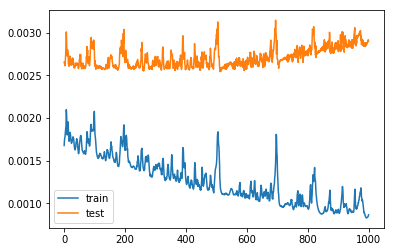

In [19]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.aggre_load_'+str(resol)+'.hdf5',
								   verbose=1, save_best_only=True)
# fit network
history = modelLoad.fit(x_train, y_train, epochs=1000, batch_size=30,
						validation_data=(x_val, y_val), verbose=2,
						callbacks=[checkpointer], shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing Model

In [14]:
# reload parameters
modelLoad.load_weights('saved_models/weights.best.aggre_load_'+str(resol)+'.hdf5')

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = modelLoad.predict(x_test)

In [24]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Square Error: %f" % mse)
print("Mean Absolute Error: %f" % mae)

Mean Square Error: 0.004621
Mean Absolute Error: 0.043567


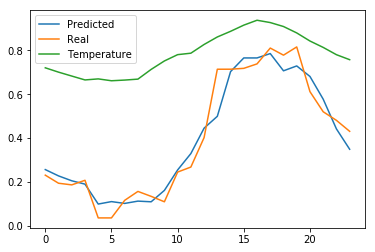

In [19]:
day = 179
plt.plot(y_pred[day,:], label='Predicted')
plt.plot(y_test[day,:], label='Real')
plt.plot(x_test[day,:,1], label='Temperature')
plt.legend()
plt.show()